<H1>Large Scale Distributed Data Science using Apache Spark </H!>

By James G. Shanahan1, 2 and Liang Dai1, 3 <P>
1 NativeX and iSchool, 2 UC Berkeley, CA, 3  UC Santa Cruz <P>

EMAIL: James_DOT_Shanahan_AT_gmail_DOT_com

#KMeans<P>
Data Generation

In [2]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

# Data Visualiazation

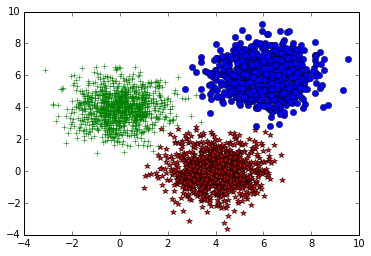

In [3]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

#Set enviroment variable for PySpark

In [1]:
import os
import sys
#Escape L for line numbers
spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.4.1-bin-hadoop2.6/'
spark_home = os.environ['SPARK_HOME'] = '/Users/jshanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.5.0-bin-hadoop2.6/'
#spark_home = os.environ['SPARK_HOME'] = '/Users/james.shanahan/Dropbox/Lectures-UC-Berkeley-ML-Class-2015/spark-1.5.0-bin-hadoop2.6/'
#spark_home = os.environ['SPARK_HOME'] = '/Users/liang/Downloads/spark-1.3.0-bin-hadoop2.4/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.0
      /_/

Using Python version 2.7.10 (default, May 28 2015 17:04:42)
SparkContext available as sc, HiveContext available as sqlContext.


In [14]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

##Distributed KMeans in Spark

Iteration0
[[ 0.80217059  0.61622248]
 [ 3.94191443  2.67285704]
 [ 2.18436067  5.72221018]]


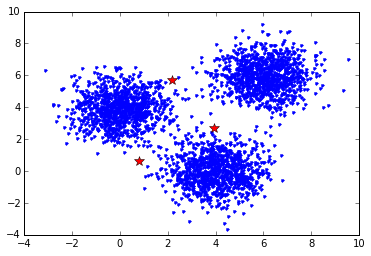

Iteration1
[[ 1.33321479  1.17692843]
 [ 5.19882955  2.38971186]
 [ 2.66060331  5.47855907]]


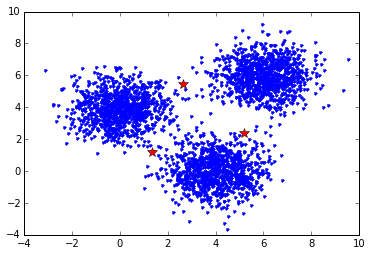

Iteration2
[[ 1.31715451  1.57091713]
 [ 5.46292687  2.32737066]
 [ 3.17137076  5.66930836]]


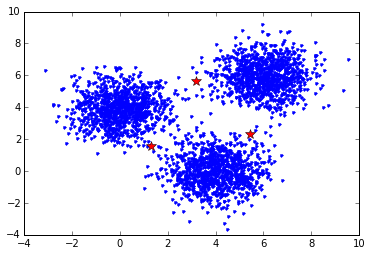

Iteration3
[[ 0.96622896  2.22551677]
 [ 5.27273743  1.59305641]
 [ 4.42203357  5.99622902]]


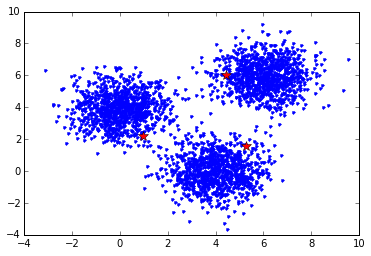

Iteration4
[[ 0.22252644  3.49901893]
 [ 4.293232    0.09445566]
 [ 5.87867771  6.02043149]]


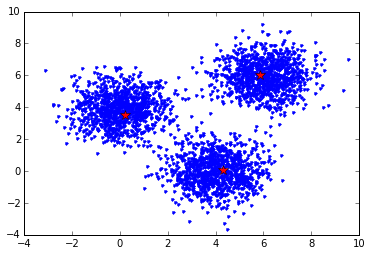

Iteration5
[[ 0.00952569  3.93468783]
 [ 4.00165948  0.01286199]
 [ 6.02417329  5.97866786]]


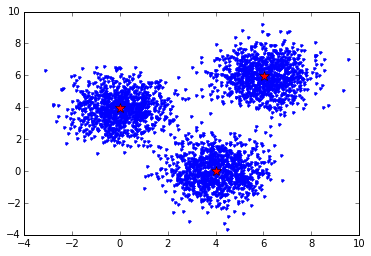

Iteration6
[[  2.66280382e-03   3.94449986e+00]
 [  3.99085070e+00   1.59474821e-02]
 [  6.02384996e+00   5.97548511e+00]]


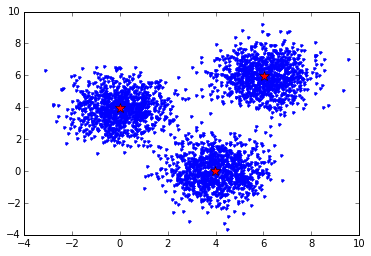

Final Results:
[[  2.66280382e-03   3.94449986e+00]
 [  3.99085070e+00   1.59474821e-02]
 [  6.02384996e+00   5.97548511e+00]]


In [15]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results:"
print centroids

#MLlib Kmeans

http://spark.apache.org/docs/latest/mllib-clustering.html

In [8]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
data = sc.textFile("data.csv")
parsedData = data.map(lambda line: array([float(x) for x in line.split(',')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 3, maxIterations=20,
        runs=10, initializationMode="random")
for centroid in clusters.centers:
    print centroid

[-0.02990683  3.97135809]
[ 5.96404527  6.00357836]
[ 4.02528864 -0.03400055]
